# Formalia:
Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment.

If you fail to follow these simple instructions, it will negatively impact your grade!

Due date and time: The assignment is due on Tuesday November 1st, 2022 at 23:55. Hand in your IPython notebook file (with extension .ipynb) via http://peergrade.io/ (we won't be doing peergrading, but we'll still use http://peergrade.io/ for the handin.)

----

# Assignment 2: Network Science

_Course: 02805 - **Social Graphs and Interactions**_ <br>
_Course responsible: **Sune Lehmann Jørgensen**_ <br>
_DTU - **Technical University of Denmark**_  
_Due date - **01/11/2022**_ <br>
_Students - **Nikos Karageorgos, John Manganas, Georgios Panagiotopoulos**_

---

## Table of Contents:
- [__Part 0: Data__](#0.)

- [__Part 1: Basic Stats__](#1.)

- [__Part 2: Communities__](#2.)

- [__Part 3: Sentiment__](#3.)

---

# Introduction  

In Assignment 2 we will be working with Superheroes from the comics series of Marvel and DC. Each hero's data is the text from the corresponding Wikipedia page.  
In [Part 0](#0.) the functions and code used to extract the data for each superhero is presented. In [Part 1](#1.) the basic sstatistics and visualisations from the produced network are illustrated. [Part 2](#2.) explores the community structure of the network and finally, in [Part 3](#3.) sentiment analysis is implemented for the 'good' and 'bad' heroes.  

For this notebook, the questions will be shown as indented text, as follows:

> Question 

The answers are shown in the subsequent text cell , starting with __Answer__: 

Before starting, we install and import of the necessary libraries:

In [42]:
from io import BytesIO
import requests
import pandas as pd
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
from tqdm.notebook import tqdm
import networkx as nx
import scipy.stats as st

Our work has been made easier by the provision of the names and wikilinks of the characters for both the DC and Marvel Universes. This data is stored as `.csv` files at the github page of the course for the [Marvel](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/files/marvel.csv) and [DC](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/files/dc.csv) universes. We have created the text files and uploaded them to a [public github repository](https://github.com/gpanagioto/projects_socialgraphs22/tree/main/Assignment2/Txt_files).

Our DC and Marvel superhero dataset after the proper extraction have been stored in a cloud PostgreSQL Database, easily and quickly accessible.

In [43]:
# Defining function for importing data from the cloud DB. The function returns two dataframes, one for each universe with two columns character_name, wiki_text
def DataImport(table_name):
  host="ec2-54-75-184-144.eu-west-1.compute.amazonaws.com"
  port="5432" 
  dbname="dab1kopm5t3l06"
  user="kpervzhazofybh" 
  password="0d1b5470c51c481880eed267865a8529bdc671f8cb90702d6dcb9e7c199d02ee"

  Engine   = create_engine('postgresql+psycopg2://{}:{}@{}:{}/{}'.format(user,password,host,port,dbname))

  # Connect to PostgreSQL server
  dbConnection = Engine.connect();

  # Read data from PostgreSQL database table and load into a DataFrame instance
  df = pd.read_sql("select * from {}".format(table_name), dbConnection)
  pd.set_option('display.expand_frame_repr', False)

  return df

The network has been saved as a `.gpickle` file and is available from the [repository](https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/SuperHeroesGraph.gpickle). In the following cell, this file is loaded and the DiGraph `G` contains the information for the superheroes network.

In [44]:
# Our Network has been stored as a pickle file in our GitHub Repository of this second assignment
mLink = 'https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/SuperHeroesGraph.gpickle?raw=true'
mfile = BytesIO(requests.get(mLink).content)
G = pickle.load(mfile)

#G_dir = pickle.load(open('/content/drive/MyDrive/DTU/02805 Social graphs and interactions/SuperHeroesGraph.gpickle', 'rb'))

Finally, the edge list for the generated network, prior to removing any nodes, has been stored in `.pickle` format in the [same public repository](https://github.com/gpanagioto/projects_socialgraphs22/blob/main/Assignment2/superheroes_edgelist.pickle). To recreate the network, the file `superheroes_edgelist.pickle` is loaded to a vriable using the `pickle` module. Then the graph is created by using `networkx`'s function [`from_edgelist`](https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_edgelist.html), passing the optional argument `create_using=nx.DiGraph`.

<a id='0.'></a>
# Part 0: Data 


__Question__:
> * Write a short paragraph describing the network. The paragraph should contain the following information
>   * The number of nodes and links.
>   * The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

As a first step, we can find and remove edges from a character to itself. This achieved by the code in following cell:

In [45]:
i=0
duplicate_edges = []
for edge in G.edges():
    if edge[0]==edge[1]:
        duplicate_edges.append(edge)
        i+=1
print(f"Number of self-edges: {i}")

# Remove self referring edges 
G.remove_edges_from(duplicate_edges)

Number of self-edges: 193


__Answer__:  
The network that has been created from the Wikipages of each character, for both universes is stored in the graph `G`. It consists of $2538$ nodes and $29998$ edges, as shown in the following cell:

In [46]:
print('The number of nodes of the network are {}.\nThe number of edges of the network are {}.'.format(G.number_of_nodes(),G.number_of_edges()))

The number of nodes of the network are 2538.
The number of edges of the network are 29805.


<a id='1.'></a>
# Part 1: Basic Stats 

This is a directed graph, since each edge has been creating pointing from the node that has a link on its wikipage towards the character that is linked. As a result, the in- and out- degrees are distinguished.  
In order to retrieve basic statistics for the network, the following function has been defined:

In [47]:
def Measures(Graph, TypeOfDegree, Data):    
    degree_type = 'Out-'
    if TypeOfDegree == 'In':
        values = list(dict(Graph.in_degree(Data)).values())
        degree_type = 'In-'
    else:
        values = list(dict(Graph.out_degree(Data)).values())
    
    print(f"{degree_type} degree statistics:\n")
    
    mean_ = np.mean(values)
    print("The average degree value is {}.".format(np.round(mean_,3)))
    median_ = np.median(values)
    print("The median is {}.".format(median_))
    mode_ = st.mode(values, keepdims=True)
    print("The mode is {}.".format(list(mode_)[0][0]))
    min_ = np.min(values)
    print("The minimum value is {}.".format(min_))
    max_ = np.max(values)
    print("The maximum value is {}.".format(max_))

    return mean_, median_, list(mode_)[0][0], min_, max_  

Using the function `Measures`, the following statistics can be calculated for the in- and out- degrees:

In [48]:
Data = list(G.nodes())
TypeOfDegree = 'In'
average, median, mode, min_, max_ = Measures(G, TypeOfDegree, Data)

In- degree statistics:

The average degree value is 11.743.
The median is 4.0.
The mode is 1.
The minimum value is 0.
The maximum value is 447.


In [49]:
Data = list(G.nodes())
TypeOfDegree = 'Out'
average, median, mode, min_, max_ = Measures(G, TypeOfDegree, Data)

Out- degree statistics:

The average degree value is 11.743.
The median is 7.0.
The mode is 0.
The minimum value is 0.
The maximum value is 111.


# TODO comment more on the degrees?

Looking at the statistics for the in- and out- degrees, it can be seen that while the average value for the degrees is over 10, the mode, especially for the out- degrees is 0. Maybe there are nodes that have no incoming or outgoing connections. The following cell investigates how many components have no incoming and outgoing connections:

In [50]:
out_degrees = np.array([degree for node,degree in G.out_degree()])
in_degrees = np.array([degree for node, degree in G.in_degree()])

print(f"There are {len(out_degrees[out_degrees==0])} nodes with out-degree equal to 0.")
print(f"There are {len(in_degrees[in_degrees==0])} nodes with in-degree equal to 0.")

# Find if there are nodes with no incoming or outgoing edges at all
idx_out_zero = np.where(out_degrees==0)[0] # Nodes with 0 out-degree
in_degrees_at_zero_out = in_degrees[idx_out_zero] # In-degrees of nodes with 0 out-degrees
print(f"There are {len(in_degrees_at_zero_out[in_degrees_at_zero_out==0])} nodes with no incoming and no outgoing connection.")


There are 975 nodes with out-degree equal to 0.
There are 137 nodes with in-degree equal to 0.
There are 2 nodes with no incoming and no outgoing connection.


However, a network this large can create some difficulties with visualisation. As in [Exercise 1, Week 5](https://github.com/SocialComplexityLab/socialgraphs2022/blob/main/lectures/Week5.ipynb), the largest weakly connected component is extracted. To this end, `networkx`'s function [`weakly_connected_components`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.weakly_connected_components.html#networkx.algorithms.components.weakly_connected_components) is used:

In [51]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
print(f"The size of the largest connected component is {len(largest_cc)} nodes, out of a total of {G.number_of_nodes()} nodes.")

The size of the largest connected component is 2534 nodes, out of a total of 2538 nodes.


Even though the largest connected component is almost all the nodes of the graph, we will use it and keep working with that as the network.

In [52]:
Gcc = G.subgraph(largest_cc)

Since the network of the largest weakly connected component is almost the same in size with the original netowrk, the degree statistics are not repeated. From now on, the term network will refer to the `Gcc`, the subgraph of the largest connected component.

__Question__:
> * We also want the degree distributions and a plot of the network
>    * Create in- and out-going degree distributions as described in Lecture 5.
>    * Estimate the slope of the incoming degree distribtion as described in Lecture 5.
>    * Plot the network using the Force Atlas algorithm as described in Lecture 5.


__Answer__:  
The in- and out- degree distributions are created for the network and visualized as histogrmas, as well as scatterplots, that can give insights into the possible correlations between the degrees. Initially, the histogrmas are plotted:

In [53]:
# Calculate the in- and out - degree distribution for Gcc
in_degrees = np.array([degree for (node, degree) in Gcc.in_degree()])
out_degrees = np.array([degree for (node, degree) in Gcc.out_degree()])

# Calculate the bin size, histogram counts and edges for the in-degree distribution
v_in = np.arange(in_degrees.min(), in_degrees.max()+1, 1)
hist_in, edges_in = np.histogram(in_degrees, bins = v_in)

# Calculate the bin size, histogram counts and edges for the out-degree distribution
v_out = np.arange(out_degrees.min(), out_degrees.max()+1, 1)
hist_out, edges_out = np.histogram(out_degrees, bins = v_out)

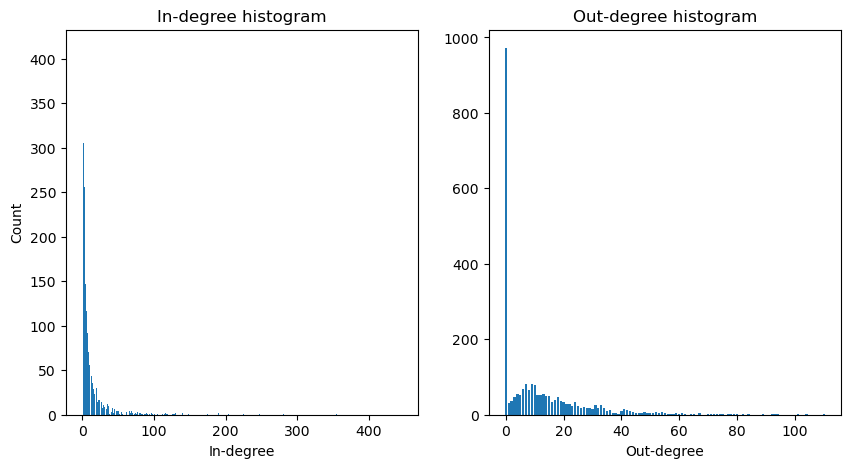

In [54]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(edges_in[:-1], hist_in)
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.title('In-degree histogram')

plt.subplot(1,2,2)
plt.bar(edges_out[:-1], hist_out)
plt.xlabel('Out-degree')
plt.title('Out-degree histogram')

plt.show()

In order to get more information regarding the network from the degree distributions, we can try to approximate the [exponent of the degree distribution](http://networksciencebook.com/chapter/4#power-laws). The exponent can give insigth in the [regime](http://networksciencebook.com/chapter/4#degree-exponent) our netowrk is in.  

In order to estimate the slope of the incoming degree distribution, which is asked in the question, the package `powerlaw` will be used.

In [55]:
# ! pip install powerlaw
import powerlaw

In [56]:
gamma_in = powerlaw.Fit(in_degrees).alpha # Estimate the degree exponent for the in-degree distribution
print(f"The estimate of the degree exponent for the in-degree is {np.round(gamma_in,3)}")

The estimate of the degree exponent for the in-degree is 2.517


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\user\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


There are three [regimes](http://networksciencebook.com/chapter/4#degree-exponent) depending on the degree exponent $\gamma$ of a network:
- Anomalous Regime ($\gamma \leq 2$)
- Scale-Free Regime ($2 < \gamma < 3$)
- Random Network Regime ($\gamma > 3$)

Looking at the _in-degree_ distribution, the network is in the scale-free regime.

The in-degree distribution can be also plotted in a log-log scale:

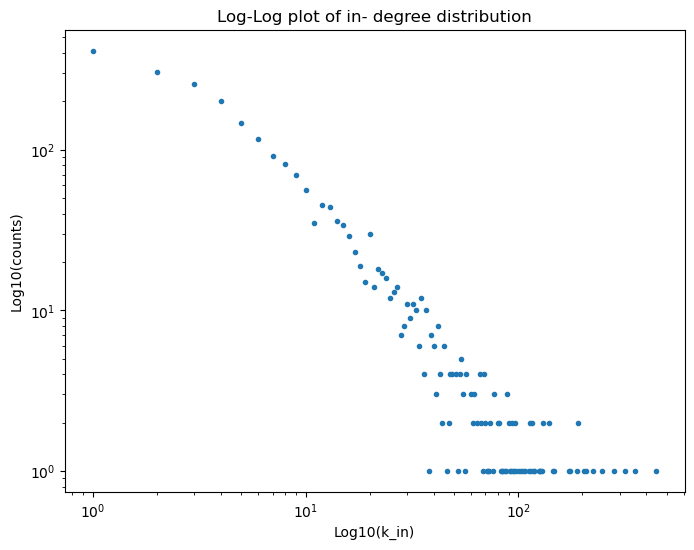

In [57]:
fig = plt.figure(figsize=(8,6))
plt.loglog(edges_in[:-1], hist_in, '.')
plt.title('Log-Log plot of in- degree distribution')
plt.xlabel('Log10(k_in)')
plt.ylabel('Log10(counts)')
plt.show()

Finally, the network is plotted using the [`ForceAtlas2`](https://github.com/bhargavchippada/forceatlas2) package. The color of each node will represent its univers, ie. DC or Marvel. It size will represent its degree. There are many nodes to visualize. We will work with the undirected version of the network graph, denoted as `G_undirected`.

In [58]:
# Import or install ForceAtlas2

# !pip install fa2
from fa2 import ForceAtlas2

In [59]:
# Create the undirected version of the graph Gcc
G_undirected = Gcc.to_undirected()

# Set the parameters to tune for the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=220.0,

                        # Log
                        verbose=True
                        )

The color of each node will depend on its `universe` attribute, <span style="color:#4a91e8">DC</span> or <span style="color:#f56653">Marvel</span> .
 The following cell creates this node color vector:

In [60]:
# Create a dictionary to make it easier to scheck connections between characters.
# It will come in handy when checking if a character connects to the same or the other universe
character_affiliation_dict = {} 

color_a = '#4a91e8' # dc - Blue
color_b = '#f56653' # marvel - Red

color_map_nodes = []
for node in G_undirected.nodes(data=True):
    if node[1]['universe'].lower()=="dc":
        color_map_nodes.append(color_a)
    else:
        color_map_nodes.append(color_b)
    character_affiliation_dict[node[0]] = node[1]['universe']

A color map can also be created for the edges. Each edge can be between  <span style="color:#a2cdfa">two DC characters</span>, <span style="color:#faafaa">two Marvel characters</span> or between two different universes, coloured black.

In [61]:
col_dc_dc = '#a2cdfa'
col_marvel_marvel = '#faafaa'
col_marvel_dc = 'k' # black for visibility

color_map_edges = []

for char1, char2 in list(G_undirected.edges()):
    if character_affiliation_dict[char1] == character_affiliation_dict[char2]:
        if character_affiliation_dict[char1].lower()[0]=='m':
            color_map_edges.append(col_marvel_marvel)
        else:
            color_map_edges.append(col_dc_dc)
    else:
        color_map_edges.append(col_marvel_dc)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:33<00:00,  9.35it/s]


BarnesHut Approximation  took  32.22  seconds
Repulsion forces  took  173.66  seconds
Gravitational forces  took  0.59  seconds
Attraction forces  took  1.19  seconds
AdjustSpeedAndApplyForces step  took  3.53  seconds


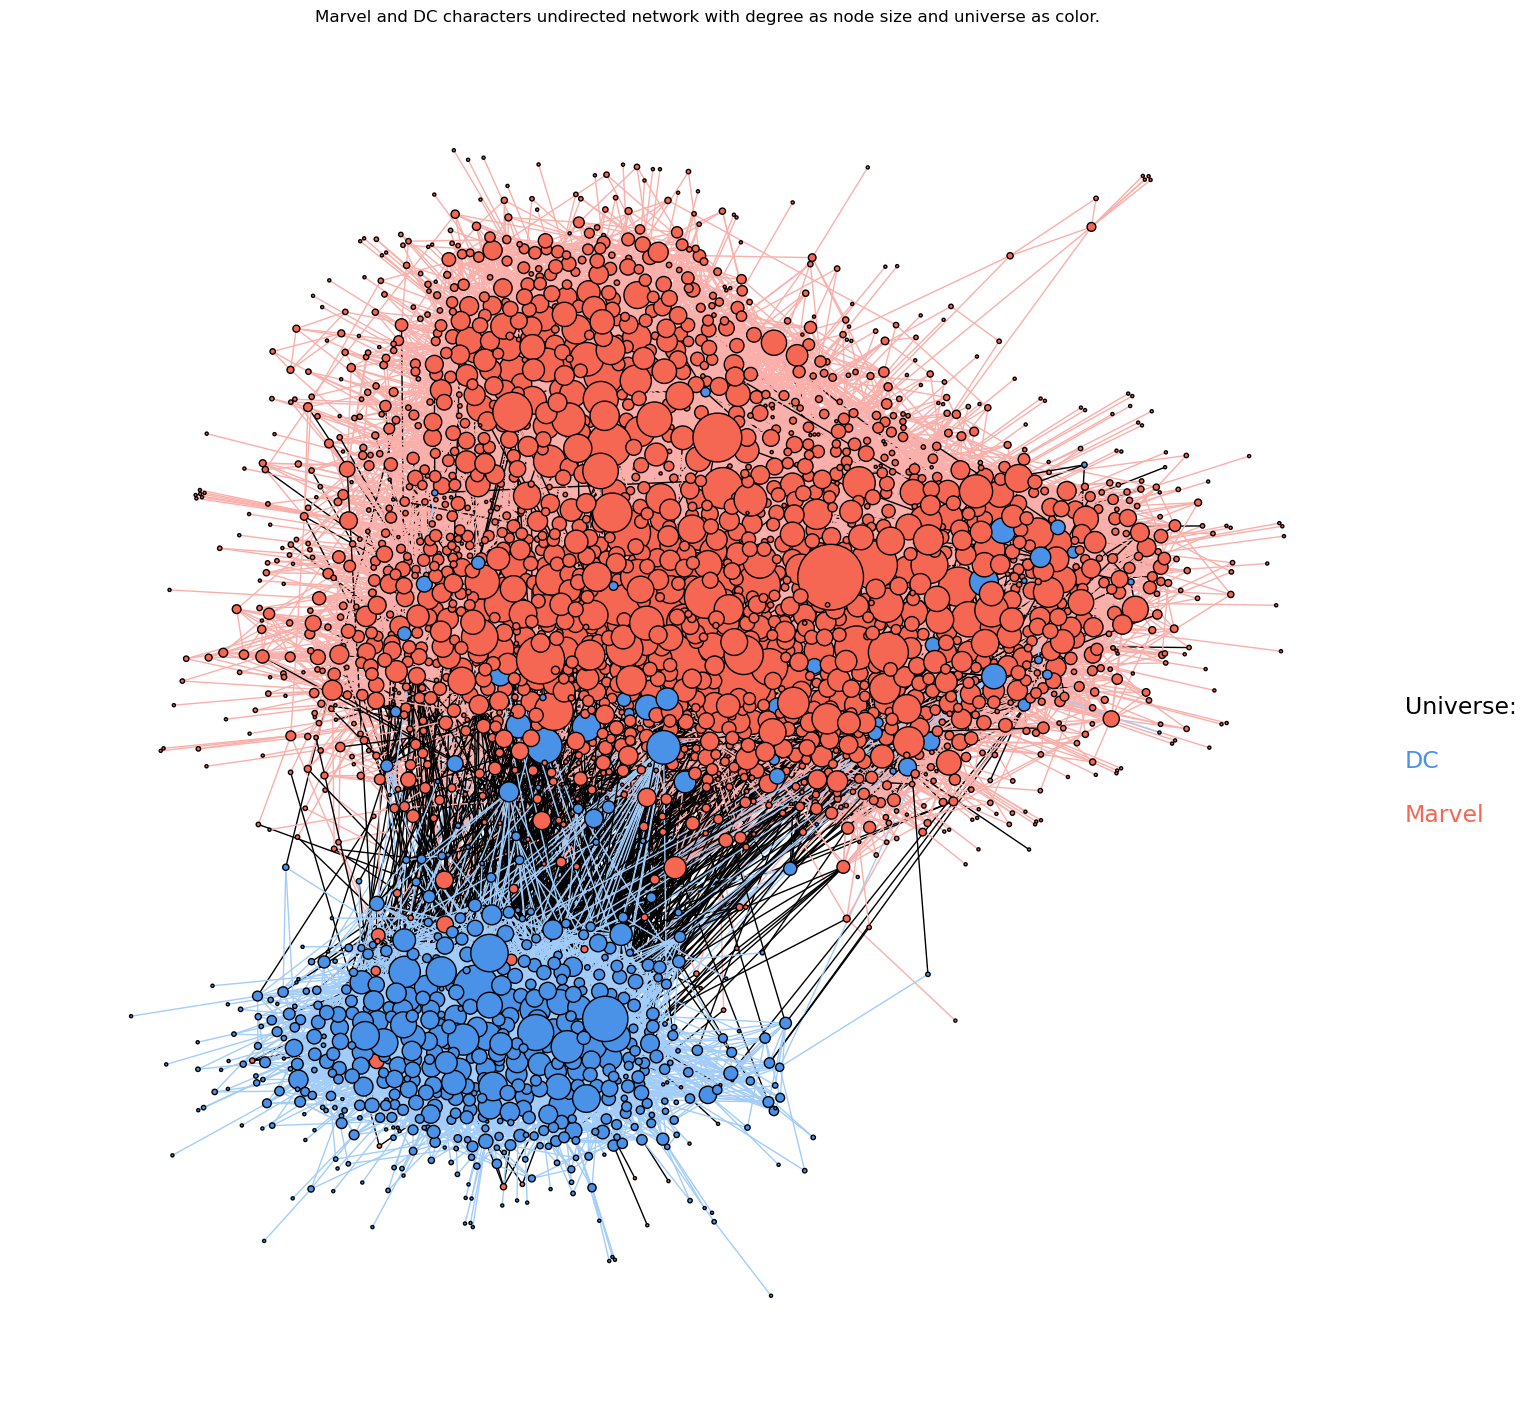

In [64]:
# Since the node size depends on the degree of the node, we need to calculate these degrees
degree_dist = np.array([deg for node, deg in G_undirected.degree()])

node_options = {
    'node_color': color_map_nodes,
    'node_size' : [deg*5  for deg in degree_dist], # node size based on degree,
    'alpha': 1,
}

iterations = 2000
fig = plt.figure(figsize=(18,18))
pos = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=iterations)
nodes = nx.draw_networkx_nodes(G_undirected, pos=pos, **node_options)
nodes.set_edgecolor('k')
nx.draw_networkx_edges(G_undirected, pos=pos,  edge_color=color_map_edges)

# Kind of legend
start_point = 0.5
plt.figtext(0.9, start_point, 'Universe:', size = 17, color = 'black')
node_col = ['#4a91e8','#f56653']
node_universe = ['DC', 'Marvel']
start_point -= 0.03
for i in range(len(node_universe)):
    plt.figtext(0.9, start_point, str(node_universe[i]), size = 17, color = node_col[i])
    start_point -= 0.03

plt.title('Marvel and DC characters undirected network with degree as node size and universe as color.')
plt.axis('off')

plt.show()

<a id='2.'></a>
# Part 2: Communities 

Quoting [Chapter 9, Network Science](http://networksciencebook.com/chapter/9#basics), a community is a locally dense subgraph in a network.  

In this section, we find for each universe the largest communities, using the Louvain algorithm [1](https://en.wikipedia.org/wiki/Louvain_method), [2](https://sites.google.com/site/findcommunities/). This is achieved by importing the library [`python-louvain`](https://perso.crans.org/aynaud/communities/), is imported as `community`. The communities are subsequently visualized and basic information regarding their size and their [modularity](http://networksciencebook.com/chapter/9#modularity) as quality metric is presented.  

Finally, for the 10 largest  communities, their text is processed and a TF-IDF vector for each community is created. A wordcloud visualization is then shown for the processed text of each community.

__Question__:  
> Identify the communities in one or both of the superhero universes (DC/Marvel).   

> Write a paragraph about your work to identify the communities. The paragraph should include
>   - Information about the algorithm you used to find communities.
>   - The value of modularity for your network.
>   - The number of communities and their sizes (in terms of number of nodes).

__Answer__:  

To recognise the communities for the respective universe, the Louvain method is used. This method is based on the [modularity](http://networksciencebook.com/chapter/9#modularity) metric, which is presented first.  

_Modularity_  
Considering a network with $N$ nodes and $L$ edges and a partition into $n_c$ communities, with each community consisting of $N_{c}$ nodes adn $L_{c}$ edges, $c=1\dots n_c$. In order to assess whether the community structure of this partition, ie. whether the sungraphs created by this partition are real communities based on local density, the modularity metric is used. It is calculated as:
$$
M=\sum_{c=1}^{n_c} \left( \frac{L_{c}}{L} - \left( \frac{k_c}{2L} \right)^{2} \right)
$$  
where $k_c$ is the total degree of the nodes in community $c$.
Modularity can have maximum value of 1 and can also have negative values. The higher the modularity, the better the partition in forming communities. If $M=0$, then the connectivity in the subgraphs is random, while if $M<0$, then the nodes in the subgraphs do not form communities.  

_Louvain algorithm_  
